## Importing relevant libraries

In [1]:
import os, cv2, imutils, shutil
from random import shuffle
import matplotlib.pyplot as plt
import mahotas as mt
from tensorflow import keras
import numpy as np

## Defining classes

In [2]:
class DataImport:

    def __init__(self):
        self.process = Processing()

    def read_image(self):
        pass

    def save_image(self, path, image):

        if isinstance(image, str):
            pass
        elif isinstance(image, list):
            for im in image:
                img = cv2.imread(im, cv2.IMREAD_COLOR)
                cv2.imwrite(path + "/" + im.split("/")[-1], img)

    def visualize_data(self, image_list, title, grid_size=(3,3)):
        
        n_rows = grid_size[0]
        n_cols = grid_size[1]
        img_count = int(n_rows * n_cols)
        f, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))
        rows = 0
        
        for ind, img in enumerate(image_list[:img_count]):
            im = cv2.imread(img, cv2.IMREAD_COLOR)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGBA)
            
            cols = ind % n_cols
            axarr[cols,rows].imshow(im)
            axarr[cols,rows].set_title(title)
            
            if cols == n_cols - 1:
                rows += 1
        
        plt.show()
        
    def manage_dirs(self, path, categories=None):
        """
        This function takes in any directory path and checks if it exists. If it does exits, then it deletes it and creates a new
        one. Once the directory is created, we go about creating categories into it, if specified
        :param path:
        :param categories:
        :return:
        """
        if os.path.exists(path):
            shutil.rmtree(path)
        os.mkdir(path)

        if categories is not None:
            if isinstance(categories, list):
                for cat in categories:
                    os.mkdir(path + "/" + cat)
            else:
                os.mkdir(path + "/" + categories)

    def create_train_test_valid(self, categories, orig_data_path, data_path, split_ratio=(0.70,0.20,0.10)):
        """
        This function is used to split data lying in different categorical folders into training, testing and validation
        Essentially our directory structure is transformed from: data
                                                                  |--> coronal
                                                                  |--> horizontal
                                                                  |--> sagittal
        to the following structure: training
                                      |--> coronal
                                      |--> horizontal
                                      |--> sagittal
                                    validation
                                      |--> coronal
                                      |--> horizontal
                                      |--> sagittal
                                    testing
                                      |--> coronal
                                      |--> horizontal
                                      |--> sagittal

        :param categories: list of output classes / categories to be predicted by the model
        :param orig_data_path: the original data path where all the data lies
        :param data_path: the path where we would create train, test and valid directories and essentially save our
        splitted data
        :param split_ratio: a tuple of 3 numbers, depicting percentage split needed in training, validation and testing
        respectively, default is (0.70, 0.20, 0.10) i.e 70%, 20% and 10%
        :return: None
        """
        # a data dictionary holds categories and a list of all the image paths
        data_dict = dict()

        # training directory path
        train_path = data_path + "/training"
        self.manage_dirs(train_path, categories)

        # validation directory path
        valid_path = data_path + "/validation"
        self.manage_dirs(valid_path, categories)

        # testing directory path
        test_path = data_path + "/testing"
        self.manage_dirs(test_path, categories)

        # loop through all the categories, make a list of all images lying in each categorical folder and append their
        # paths into a list. This list of paths corresponds to a categorical key in the dictionary
        for category in categories:
            category_dir = orig_data_path + "/" + category   # the original data path corresponding to each category

            # populate the dictionary with list of image paths belonging to a particular class
            data_dict[category] = [category_dir + "/" + file for file in os.listdir(category_dir) if not file.startswith('.')]
            shuffle(data_dict[category])   # randomly shuffle the list of image paths

            # based on user provided percentage split list, split the given data for training, validation and testing
            training = data_dict[category][:int(len(data_dict[category]) * split_ratio[0])]
            validation = data_dict[category][int(len(data_dict[category]) * split_ratio[0]):
                                             int(len(data_dict[category]) * sum(split_ratio[:2]))]
            testing = data_dict[category][int(len(data_dict[category]) * sum(split_ratio[:2])):]

            # once the randomly shuffled data is split based on percentage we would want to read them from their
            # original directory and write them to a new location based on whether they are training, validation or
            # testing and further based on whether they are coronal, horizontal or sagittal.
            self.save_image(train_path + "/" + category, training)
            self.save_image(valid_path + "/" + category, validation)
            self.save_image(test_path + "/" + category, testing)

        return train_path, valid_path, test_path

    def create_data_matrices(self, categories, data_path, colormap):

        data_matrix = list()
        label_matrix = list()
        for index, category in enumerate(categories):
            path = os.path.join(data_path, category)

            for img in os.listdir(path):
                try:
                    image = self.process.read_image(os.path.join(path, img), colormap)

                    data_matrix.append(image)
                    label_matrix.append(index)
                except Exception as e:
                    print(e)

        return data_matrix, label_matrix

In [3]:
class Processing:

    def __init__(self):
        pass

    @staticmethod
    def display_image(image):
        plt.imshow(image)
        plt.show()

    @staticmethod
    def read_image(image_path, color_space=None):
        color_map = {'BGR2RGBA': cv2.COLOR_BGR2RGBA,
                     'BGR2GRAY': cv2.COLOR_BGR2GRAY,
                     'BGR2RGB': cv2.COLOR_BGR2RGB,
                     'BGR2BGRA': cv2.COLOR_BGR2BGRA,
                     'ORIGINAL': cv2.IMREAD_COLOR
                     }

        # read the input image and convert it from BGR to BGRA
        img = cv2.imread(image_path, color_map['ORIGINAL'])  # read the color image

        if color_space != 'ORIGINAL' and color_space is not None:
            # convert from 3 channel BGR to RGBA taking into consideration alpha
            img = cv2.cvtColor(img, color_map[color_space])

        return img

    @staticmethod
    def image_resize_with_aspect(height, width, img_path, fit_style, temp_path, color_map, padding="white", debug=False):

        if isinstance(img_path, np.ndarray):
            img = img_path
        else:
            img = Processing.read_image(img_path, color_map)

        if debug:
            Processing.display_image(img)

        # get the shape of the image
        if "GRAY" in color_map:
            img_h, img_w = img.shape
            depth = 1
        else:
            img_h, img_w, depth = img.shape  # returns (height, width, depth)

        # find the aspect ratio of the actual image and the desired image
        image_aspect = float(img_w / img_h)
        desired_aspect = float(width / height)
        print("original image height, width and depth:", img_h, img_w, depth)

        # resizing the image maintaining the aspect ratio. This is a function to resize it to a square
        if fit_style == "square":

            if image_aspect > desired_aspect:
                img_h = int(width / image_aspect)
                img_w = width
            elif image_aspect < desired_aspect:
                img_w = int(height * image_aspect)
                img_h = height
            else:
                img_w = width
                img_h = height

        print("new width and height: ", img_w, img_h)

        # resizing the image and displaying it.
        new_img = cv2.resize(img, (int(img_w), int(img_h)), interpolation=cv2.INTER_AREA)
        if debug:
            Processing.display_image(new_img)

        if padding is not None:
            # TIP: 0, 1 and border extension logic
            # create a black image using numpy and the alpha channel
            val = 0
            if padding == "extend":
                val = int((np.mean(img[0:5,:]) + np.mean(img[-5:,:])) / 2)
                print("Val :", val)
            elif padding == "white":
                val = 255
            elif padding == "black":
                val = 0

            back_img = np.ones((height, width, 3), np.float32) * val
            cv2.imwrite(temp_path + "/image.png", back_img)
            black_img = Processing.read_image(temp_path + "/image.png", color_map)

            # based on the resized image shapes, paste the original image on the  canvas with relevant offsets
            if img_w == width:
                mid_y = int(height / 2) - int(img_h / 2)
                black_img[mid_y:mid_y + img_h, :] = new_img
            elif img_h == height:
                mid_x = int(width / 2) - int(img_w / 2)
                black_img[:, mid_x:mid_x + img_w] = new_img
            else:
                black_img = new_img
        else:
            black_img = new_img

        if debug:
            Processing.display_image(black_img)

        return black_img

    @staticmethod
    def resize_images(x_size, y_size, image, colormap, temp_path):

        if isinstance(image, list):
            image_matrix = list()
            for img in image:
                resized_image = Processing.image_resize_with_aspect(y_size, x_size, img, "square", temp_path, colormap,
                                                                    "extend", False)
                # resized_image = cv2.resize(img, (x_size, y_size))
                image_matrix.append(resized_image)
            return image_matrix
        else:
            resized_image = Processing.image_resize_with_aspect(y_size, x_size, image, "square", temp_path, colormap,
                                                                "extend", False)
            return resized_image

    @staticmethod
    def change_datatype(data, dataType):
        new_data = data.astype(dataType)
        return new_data

    @staticmethod
    def scale_images(data, factor):
        data = data / factor
        return data

In [4]:
class CNN:
    
    def __init__(self):
        pass
    
    @staticmethod
    def create_model(input_shape, final_activation, layer_activation, conv_layers, dense_layers, no_of_filters,
                     filter_size, pool_size, final_dense_neurons, kernel_initializer):
        model = keras.Sequential()

        activations_dict = {"RELU": tf.nn.relu,
                            "LEAKY_RELU": tf.nn.leaky_relu,
                            "TANH": tf.nn.tanh,
                            "SOFTMAX": tf.nn.softmax}

        initializer_dict = {"ZEROS": tf.keras.initializers.Zeros,
                            "UNIFORM": tf.keras.initializers.uniform,
                            "RAND_NORM": tf.keras.initializers.random_normal,
                            "RAND_UNIF": tf.keras.initializers.random_uniform}

        for i in range(conv_layers):
            model.add(tf.keras.layers.Conv2D(no_of_filters[i], (filter_size[i], filter_size[i]), input_shape=input_shape,
                                             activation=activations_dict[layer_activation]))
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size[i], pool_size[i])))
            model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors

        hidden_units = 64

        for i in range(dense_layers):
            model.add(tf.keras.layers.Dense(hidden_units, kernel_initializer=initializer_dict[kernel_initializer]))
            model.add(tf.keras.layers.BatchNormalization(axis=1))
            model.add(tf.keras.layers.Activation(activations_dict[final_activation]))

        model.add(tf.keras.layers.Dense(final_dense_neurons))
        model.add(tf.keras.layers.Activation(activations_dict[final_activation]))

        return model

## Traversing directories

In [5]:
os.getcwd()  # get the current directory
os.chdir('../data/stitched')  # change the directory to where data lies
os.getcwd()  # get the current directory

# get list of all the classes
classes = [folder for folder in os.listdir(os.getcwd()) if not folder.startswith('.')] 
print("Classes: ", classes)
class_paths = [os.getcwd() + "/" + cls for cls in classes]
print("Class_paths: ", class_paths)

Classes:  ['sagittal', 'horizontal', 'coronal']
Class_paths:  ['/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/horizontal', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/coronal']


## Creating image path directories

In [6]:
# dictionary to hold image paths of individual sub directories
image_path_dict = dict()
for ind, cls in enumerate(class_paths):
    os.chdir(cls)
    image_path_dict[classes[ind]] = [os.getcwd() + "/" + img for img in os.listdir(os.getcwd()) if not img.startswith('.')]

print(image_path_dict)

{'sagittal': ['/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m19a_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m07a_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m42e_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m15a_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m11d_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m40a_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m09e_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_m39d_3.png', '/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/sagittal/sag-highres_

## Visualizing some images of each category

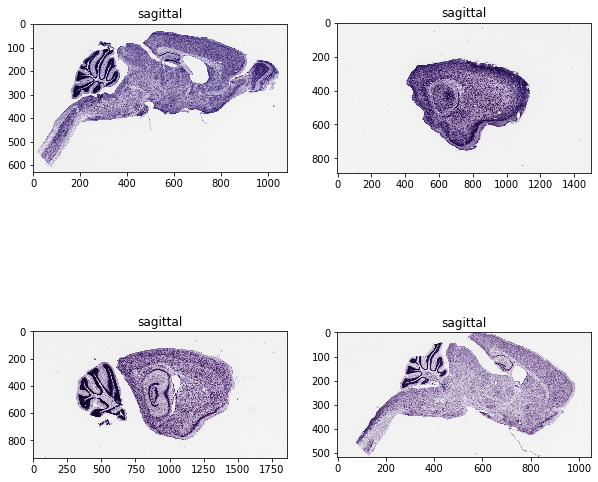

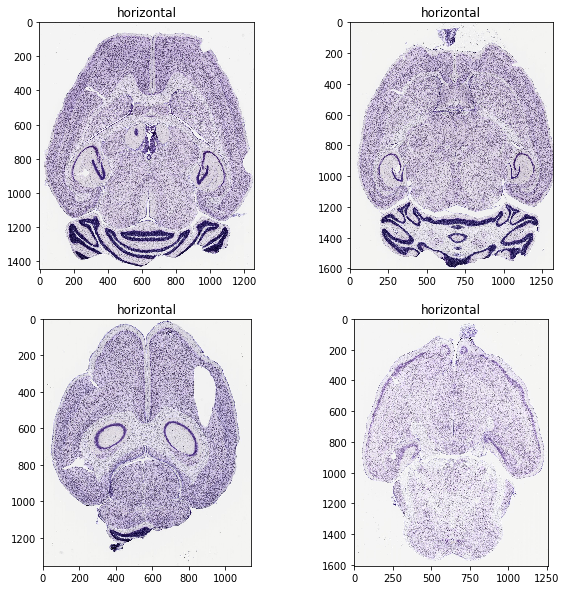

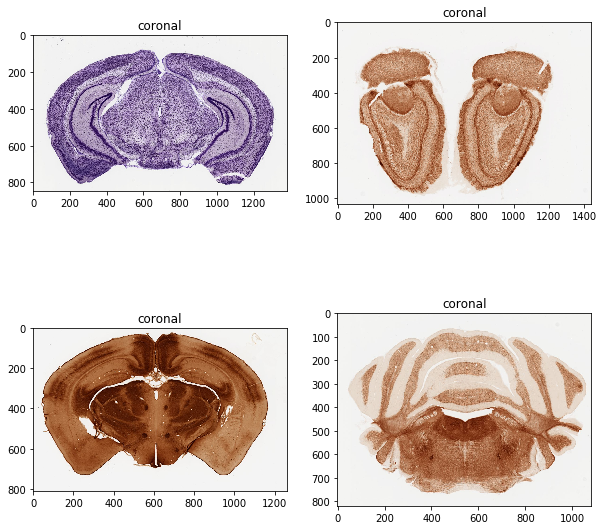

In [7]:
di = DataImport()
    
for cls in classes:
    di.visualize_data(image_path_dict[cls], cls, (2,2))

In [8]:
im = cv2.imread(image_path_dict['coronal'][0], cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
textures = mt.features.haralick(im)
ht_mean = textures.mean(axis=0)
ht_mean.shape

(13,)

In [12]:
class Brain:

    def __init__(self, debug):
        self.debug = debug

#     def get_directory_paths(self, file_name):

#         # getting the code path, which is the current directory
#         code_path = os.path.dirname(os.path.abspath(file_name))
#         os.chdir("..")   # changing one directory up
#         root_path = os.getcwd()
#         temp_path = os.getcwd() + "/temp"   # creating the temp path for storing temporary runtime files

#         # if a temporary directory exists, then remove it
#         if os.path.exists(temp_path):
#             print("It exists")
#             shutil.rmtree(temp_path)
#         os.mkdir(temp_path)   # create a new temporary directory for the current run
#         os.chdir("data/stitched")   # change to the data directory where all the class folders lie
#         orig_data_path = os.getcwd()  # get the data directory path
#         os.chdir("../")
#         print(os.getcwd())
#         data_path = os.getcwd()
#         os.chdir(root_path)

#         # if in DEBUG mode, print this out to the console
#         if self.debug:
#             print("Code path: ", code_path)
#             print("Data path: ", orig_data_path)
#             print("Temp path:", temp_path)

#         return code_path, orig_data_path, temp_path, data_path, root_path
    code_path = "/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/notebooks/"
    orig_data_path = "/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/stitched/"
    data_path = "/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/data/"
    temp_path = "/Users/nikunjlad/RA/broad/Broad-Institute-Mouse-Brain-Mapping/temp/"

    def main(self):

        # get the directory paths for use throughout the code
#         code_path, orig_data_path, temp_path, data_path, root_path = self.get_directory_paths("Image Processing.ipynb")

        # get the classes
        categories = [folder for folder in os.listdir(self.orig_data_path) if not folder.startswith('.')]

        if self.debug:
            print("Categories :", categories)

        Img_Size = [512, 512]

        di = DataImport()
        train_test_split = True

        if not train_test_split:
            # takes folder of images and splits them into train, test, valid and returns those paths
            train_path, valid_path, test_path = di.create_train_test_valid(categories, self.orig_data_path, self.data_path)
        else:
            train_path = self.data_path + "/training"
            valid_path = self.data_path + "/validation"
            test_path = self.data_path + "/testing"

        # pass the training, validation, test dir paths and get the train, test, validation matrices
        colormap = 'ORIGINAL'
        train_data, train_label = di.create_data_matrices(categories, train_path, colormap)
        valid_data, valid_label = di.create_data_matrices(categories, valid_path, colormap)
        test_data, test_label = di.create_data_matrices(categories, test_path, colormap)

        # resize images to a predefined size
        proc = Processing()
        train_matrix = proc.resize_images(Img_Size[0], Img_Size[1], train_data, colormap, self.temp_path)
        valid_matrix = proc.resize_images(Img_Size[0], Img_Size[1], valid_data, colormap, self.temp_path)
        test_matrix = proc.resize_images(Img_Size[0], Img_Size[1], test_data, colormap, self.temp_path)

original image height, width and depth: 630 1080 3
new width and height:  512 298
Val : 241
original image height, width and depth: 888 1500 3
new width and height:  512 303
Val : 241
original image height, width and depth: 515 1050 3
new width and height:  512 251
Val : 240
original image height, width and depth: 888 1500 3
new width and height:  512 303
Val : 243
original image height, width and depth: 928 1860 3
new width and height:  512 255
Val : 243
original image height, width and depth: 888 1500 3
new width and height:  512 303
Val : 243
original image height, width and depth: 511 1110 3
new width and height:  512 235
Val : 234
original image height, width and depth: 888 1920 3
new width and height:  512 236
Val : 243
original image height, width and depth: 969 1980 3
new width and height:  512 250
Val : 243
original image height, width and depth: 888 1500 3
new width and height:  512 303
Val : 243
original image height, width and depth: 888 1500 3
new width and height:  512 30

Val : 242
original image height, width and depth: 888 1500 3
new width and height:  512 303
Val : 241
original image height, width and depth: 928 1860 3
new width and height:  512 255
Val : 243
original image height, width and depth: 928 1860 3
new width and height:  512 255
Val : 243
original image height, width and depth: 508 1080 3
new width and height:  512 240
Val : 241
original image height, width and depth: 928 1860 3
new width and height:  512 255
Val : 243
original image height, width and depth: 630 1110 3
new width and height:  512 290
Val : 236
original image height, width and depth: 579 1170 3
new width and height:  512 253
Val : 240
original image height, width and depth: 1023 1980 3
new width and height:  512 264
Val : 238
original image height, width and depth: 630 1080 3
new width and height:  512 298
Val : 238
original image height, width and depth: 579 1170 3
new width and height:  512 253
Val : 238
original image height, width and depth: 515 1050 3
new width and heig

original image height, width and depth: 1640 1320 3
new width and height:  412 512
Val : 243
original image height, width and depth: 1328 1260 3
new width and height:  485 512
Val : 242
original image height, width and depth: 1728 1380 3
new width and height:  408 512
Val : 239
original image height, width and depth: 1606 1320 3
new width and height:  420 512
Val : 240
original image height, width and depth: 1606 1200 3
new width and height:  382 512
Val : 242
original image height, width and depth: 1484 1320 3
new width and height:  455 512
Val : 241
original image height, width and depth: 1606 1260 3
new width and height:  401 512
Val : 241
original image height, width and depth: 1823 1320 3
new width and height:  370 512
Val : 245
original image height, width and depth: 1660 1320 3
new width and height:  407 512
Val : 241
original image height, width and depth: 1572 1260 3
new width and height:  410 512
Val : 242
original image height, width and depth: 1504 1260 3
new width and heig

Val : 242
original image height, width and depth: 1559 1320 3
new width and height:  433 512
Val : 241
original image height, width and depth: 1640 1560 3
new width and height:  487 512
Val : 243
original image height, width and depth: 1294 1140 3
new width and height:  451 512
Val : 240
original image height, width and depth: 1742 1380 3
new width and height:  405 512
Val : 242
original image height, width and depth: 1660 1380 3
new width and height:  425 512
Val : 242
original image height, width and depth: 1511 1260 3
new width and height:  426 512
Val : 243
original image height, width and depth: 1443 1380 3
new width and height:  489 512
Val : 240
original image height, width and depth: 1552 1260 3
new width and height:  415 512
Val : 243
original image height, width and depth: 1220 1140 3
new width and height:  478 512
Val : 242
original image height, width and depth: 1206 1080 3
new width and height:  458 512
Val : 242
original image height, width and depth: 1518 1200 3
new widt

Val : 242
original image height, width and depth: 1437 2040 3
new width and height:  512 360
Val : 243
original image height, width and depth: 806 1140 3
new width and height:  512 361
Val : 242
original image height, width and depth: 861 1320 3
new width and height:  512 333
Val : 242
original image height, width and depth: 1166 1560 3
new width and height:  512 382
Val : 243
original image height, width and depth: 834 1320 3
new width and height:  512 323
Val : 242
original image height, width and depth: 806 1200 3
new width and height:  512 343
Val : 243
original image height, width and depth: 1003 1320 3
new width and height:  512 389
Val : 242
original image height, width and depth: 773 1200 3
new width and height:  512 329
Val : 243
original image height, width and depth: 874 1380 3
new width and height:  512 324
Val : 242
original image height, width and depth: 1180 1200 3
new width and height:  512 503
Val : 242
original image height, width and depth: 800 1260 3
new width and h

Val : 242
original image height, width and depth: 1234 1680 3
new width and height:  512 376
Val : 242
original image height, width and depth: 1410 2040 3
new width and height:  512 353
Val : 243
original image height, width and depth: 806 1140 3
new width and height:  512 361
Val : 242
original image height, width and depth: 1465 1680 3
new width and height:  512 446
Val : 243
original image height, width and depth: 779 1200 3
new width and height:  512 332
Val : 241
original image height, width and depth: 786 1200 3
new width and height:  512 335
Val : 243
original image height, width and depth: 1384 1680 3
new width and height:  512 421
Val : 240
original image height, width and depth: 813 1260 3
new width and height:  512 330
Val : 242
original image height, width and depth: 868 1080 3
new width and height:  512 411
Val : 241
original image height, width and depth: 867 1380 3
new width and height:  512 321
Val : 242
original image height, width and depth: 718 1080 3
new width and h

original image height, width and depth: 901 1500 3
new width and height:  512 307
Val : 241
original image height, width and depth: 1302 1920 3
new width and height:  512 347
Val : 243
original image height, width and depth: 874 1380 3
new width and height:  512 324
Val : 242
original image height, width and depth: 746 1200 3
new width and height:  512 318
Val : 243
original image height, width and depth: 847 1260 3
new width and height:  512 344
Val : 242
original image height, width and depth: 963 1320 3
new width and height:  512 373
Val : 243
original image height, width and depth: 718 1080 3
new width and height:  512 340
Val : 241
original image height, width and depth: 915 1380 3
new width and height:  512 339
Val : 240
original image height, width and depth: 820 1140 3
new width and height:  512 368
Val : 241
original image height, width and depth: 1437 2040 3
new width and height:  512 360
Val : 242
original image height, width and depth: 1302 1920 3
new width and height:  512

Val : 242
original image height, width and depth: 1416 1320 3
new width and height:  477 512
Val : 242
original image height, width and depth: 1430 1260 3
new width and height:  451 512
Val : 242
original image height, width and depth: 1864 1320 3
new width and height:  362 512
Val : 244
original image height, width and depth: 1708 1320 3
new width and height:  395 512
Val : 243
original image height, width and depth: 1695 1560 3
new width and height:  471 512
Val : 243
original image height, width and depth: 2020 2040 3
new width and height:  512 506
Val : 243
original image height, width and depth: 1437 1200 3
new width and height:  427 512
Val : 242
original image height, width and depth: 1701 1380 3
new width and height:  415 512
Val : 241
original image height, width and depth: 1796 1260 3
new width and height:  359 512
Val : 245
original image height, width and depth: 1511 1080 3
new width and height:  365 512
Val : 245
original image height, width and depth: 1613 1560 3
new widt

original image height, width and depth: 712 1140 3
new width and height:  512 319
Val : 243
original image height, width and depth: 739 1080 3
new width and height:  512 350
Val : 241
original image height, width and depth: 895 1200 3
new width and height:  512 381
Val : 243
original image height, width and depth: 1207 1560 3
new width and height:  512 396
Val : 243
original image height, width and depth: 1451 2040 3
new width and height:  512 364
Val : 243
original image height, width and depth: 949 1200 3
new width and height:  512 404
Val : 242
original image height, width and depth: 718 1080 3
new width and height:  512 340
Val : 243
original image height, width and depth: 813 1380 3
new width and height:  512 301
Val : 240
original image height, width and depth: 691 1200 3
new width and height:  512 294
Val : 241
original image height, width and depth: 1248 1680 3
new width and height:  512 380
Val : 243
original image height, width and depth: 745 1200 3
new width and height:  512

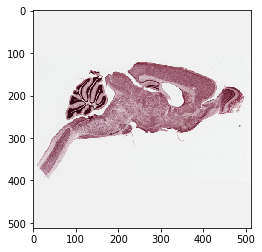

NameError: name 'sys' is not defined

In [11]:
b = Brain(debug=False)
b.main()

In [ ]:
plt.imshow(b.main().train_matrix[1])
cv2.imwrite(self.temp_path + "/sample.png",train_matrix[1])
plt.show()